In [1]:
# import pytorch libraries
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from torch_geometric.deprecation import deprecated

import os
import csv
import copy
import math
import time
import random
import pickle
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tools.eval_measures import mse
from decimal import Decimal
from scipy import stats
from scipy.stats import spearmanr, rankdata, norm
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

In [2]:
# generate prediction for every tissue
t_epoch = 300
f_epoch = 500
status = 'trainable'
missing_N = 5
    
# save the dictionary
save_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/ATG_8_or_less/Prediction/'
if f_epoch==0:
    dict_name = f'gtex_allen_region_epoch_{t_epoch}_missing_N_{missing_N}.pickle'
else:
    dict_name = f'gtex_allen_region_trainable_GNN_af_epoch_{t_epoch}_fepoch_{f_epoch}_missing_N_{missing_N}.pickle'
# # Writing the dictionary to a file using pickle
# with open(save_dir+dict_name, 'wb') as f:
#     pickle.dump(go_prediction_dict, f)
# Reading the pickled data from file
with open(save_dir+dict_name, 'rb') as f:
    go_prediction_dict = pickle.load(f)

In [3]:
go_prediction_dict['GTEX-1192X']

,4012,4013,4014,4023,4024,4030,4031,4039,4045,4048,...,9161,9492,9520,9543,9561,9598,9614,9677,9698,13005
A1BG,-1.071822,-1.124489,-1.120417,-1.116274,-1.093049,-1.069136,-1.036455,-1.064823,-1.076305,-1.061219,...,-0.427915,-0.446719,-0.519701,-0.187329,-0.354446,-0.278957,-0.441962,-0.324463,-0.187972,-1.663585
A2M,-0.321535,-0.271735,-0.334041,-0.294921,-0.325002,-0.287072,-0.262167,-0.307535,-0.287351,-0.402911,...,0.324926,0.364084,0.272341,0.568526,0.545489,0.572865,0.471511,0.485765,0.576922,0.413119
A2ML1,0.529571,0.532547,0.497321,0.545011,0.531000,0.502353,0.514838,0.497690,0.505876,0.494028,...,0.530487,0.356032,0.238875,0.698179,0.615878,0.686164,0.554550,0.799810,0.725166,-0.262813
A4GALT,-0.522837,-0.514236,-0.525258,-0.512837,-0.503379,-0.500135,-0.471632,-0.502154,-0.507762,-0.566371,...,-0.034490,-0.065919,-0.086398,0.204664,0.127550,0.195034,0.009866,0.058402,0.209453,0.077166
A4GNT,-0.610929,-0.540533,-0.597600,-0.543887,-0.586465,-0.543986,-0.530006,-0.583874,-0.519135,-0.567448,...,-0.424640,-0.385631,-0.412698,-0.460138,-0.413561,-0.438406,-0.460774,-0.432328,-0.452939,-0.415857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,-1.527172,-1.621500,-1.605077,-1.593102,-1.561768,-1.551077,-1.527896,-1.542054,-1.567873,-1.484603,...,-0.267894,-0.263665,-0.293055,0.057198,0.093904,0.116046,-0.158506,-0.038065,0.083898,-0.608521
ZYG11B,1.776216,1.914783,1.887111,1.907524,1.837100,1.839934,1.838018,1.799699,1.902088,1.762440,...,0.253803,0.438815,0.305602,0.158985,0.326877,0.305460,0.295198,0.127466,0.227659,1.560273
ZYX,0.065504,0.116427,0.019524,0.113709,0.063903,0.052234,0.069881,0.015489,0.123820,-0.031446,...,-0.434854,-0.287321,-0.369723,-0.276817,-0.277132,-0.287180,-0.354082,-0.406570,-0.262986,-0.742509
ZZEF1,-1.248068,-1.319799,-1.336237,-1.289090,-1.268788,-1.251017,-1.221679,-1.260964,-1.230472,-1.294336,...,-0.214633,-0.137338,-0.246980,0.163029,0.195020,0.295525,-0.077934,-0.027904,0.278200,-0.305865


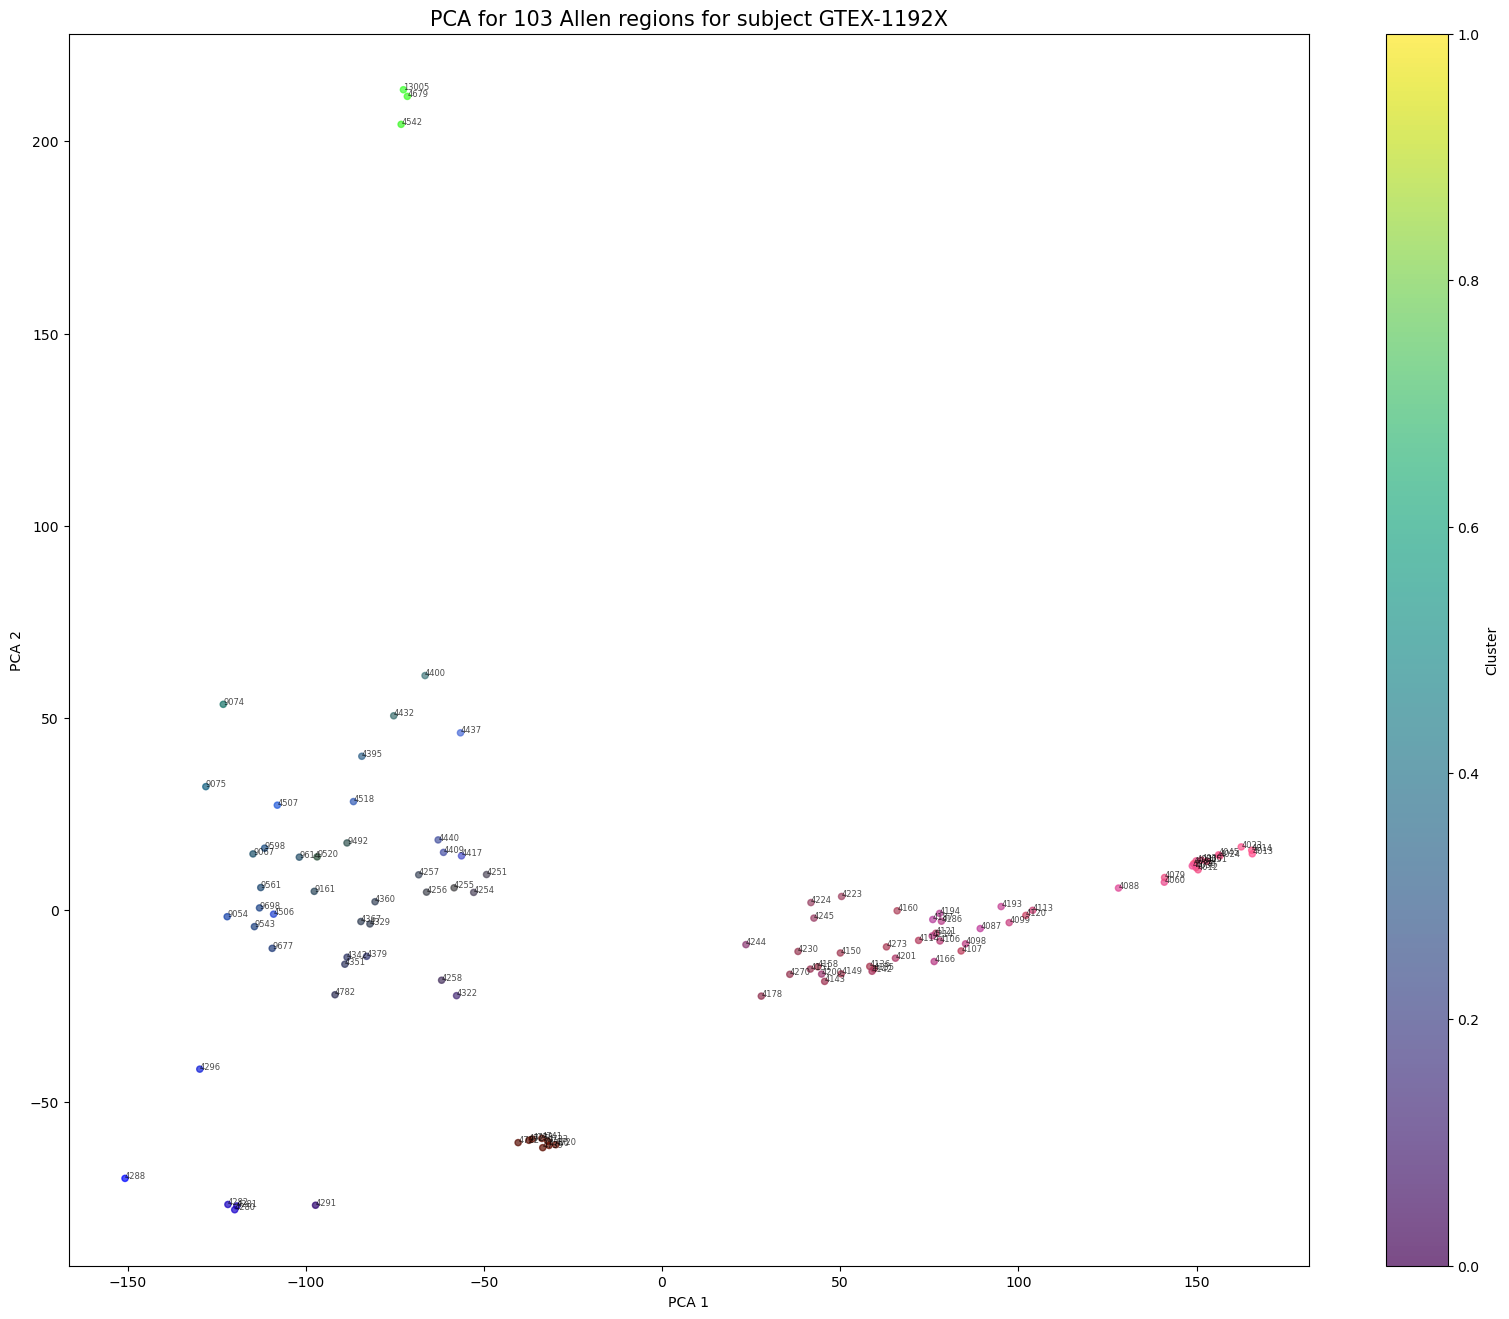

In [4]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Example: Load your data into a pandas DataFrame
# Replace this with your actual data
subject = 'GTEX-1192X'
mat = go_prediction_dict[subject].values.T
region_names = go_prediction_dict[subject].columns

# Step 1: Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(mat)

# Step 2: Apply PCA to reduce data to 3 components (3D)
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_scaled)

# Step 3: Normalize all three PCA components to the range [0, 1] for coloring
norm_pca_1 = (pca_result[:, 0] - pca_result[:, 0].min()) / pca_result[:, 0].ptp()  # Normalize PCA 1
norm_pca_2 = (pca_result[:, 1] - pca_result[:, 1].min()) / pca_result[:, 1].ptp()  # Normalize PCA 2
norm_pca_3 = (pca_result[:, 2] - pca_result[:, 2].min()) / pca_result[:, 2].ptp()  # Normalize PCA 3

# Step 4: Create colors based on all three PCA components
colors = np.zeros((pca_result.shape[0], 3))  # RGB color array
colors[:, 0] = norm_pca_1  # Red channel based on PCA 1
colors[:, 1] = norm_pca_2  # Green channel based on PCA 2
colors[:, 2] = norm_pca_3  # Blue channel based on PCA 3

# Step 5: Plot the PCA result for the first two components, coloring each point based on all three components
plt.figure(figsize=(20, 16))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=colors, s=20, alpha=0.7)

# Step 6: Annotate the dots with row names
for i, txt in enumerate(region_names):
    plt.annotate(txt, (pca_result[i, 0], pca_result[i, 1]), fontsize=6, alpha=0.7)

plt.title(f'PCA for 103 Allen regions for subject {subject}', fontsize=15)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

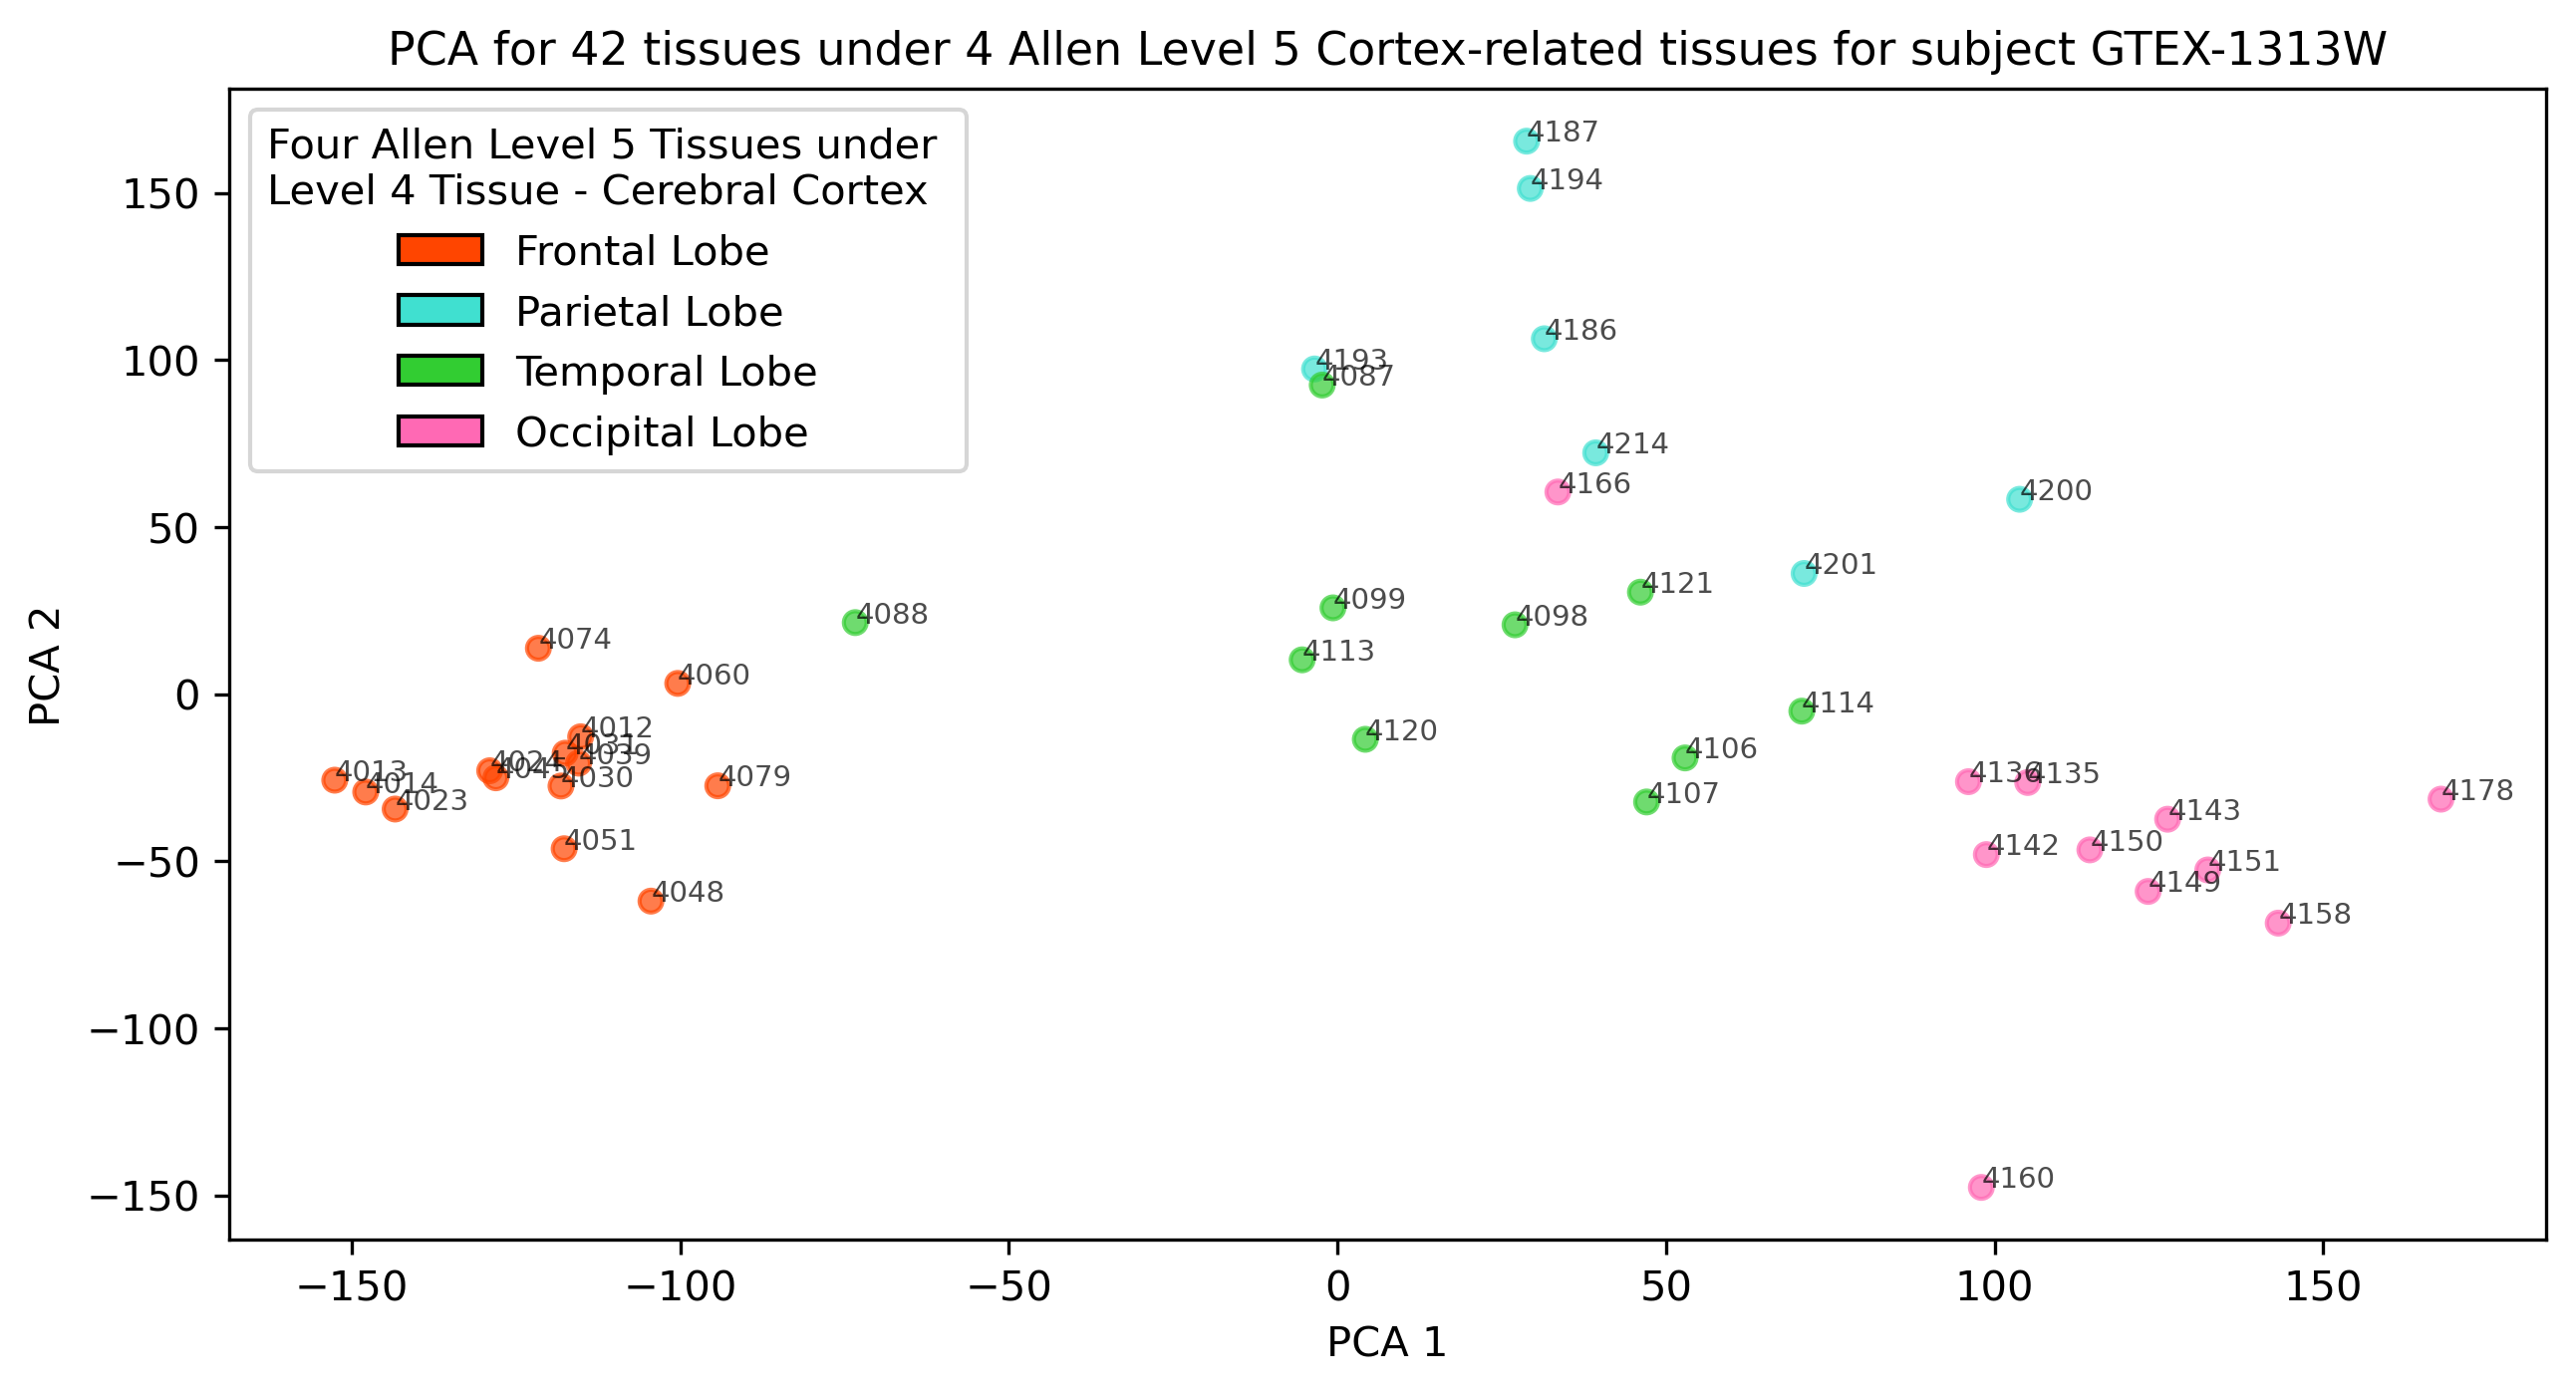

In [12]:
# A new plot with only the CORTEX allen region
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Patch

region_matching = {'Frontal Lobe': ['4012', '4013', '4014', '4023', '4024', '4030', '4031', '4039', '4045', '4048', '4051', '4060', '4074', '4079'], 
                   'Insula': ['4270', '4273'], 
                   'Limbic Lobe': ['4223', '4224', '4230', '4244', '4245', '4251', '4254', '4255', '4258'], 
                   'Parietal Lobe': ['4186', '4187', '4193', '4194', '4200', '4201', '4214'], 
                   'Temporal Lobe': ['4087', '4088', '4098', '4099', '4106', '4107', '4113', '4114', '4120', '4121'], 
                   'Occipital Lobe': ['4135', '4136', '4142', '4143', '4149', '4150', '4151', '4158', '4160', '4166', '4178']}

picked_sub = ['Frontal Lobe', 'Parietal Lobe', 'Temporal Lobe', 'Occipital Lobe']
picked_col = region_matching[picked_sub[0]] + region_matching[picked_sub[1]]+ region_matching[picked_sub[2]] + region_matching[picked_sub[3]]
n_dots = [len(region_matching[key]) for key in picked_sub]
picked_color = ['#FF4500', '#40E0D0', '#32CD32', '#FF69B4']
colors_list = [color for color, count in zip(picked_color, n_dots) for _ in range(count)]

subject = 'GTEX-1313W'
# subject = list(go_prediction_dict.keys())[0]
mat = go_prediction_dict[subject][picked_col].values.T
region_names = picked_col

# Step 1: Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(mat)

# Step 2: Apply PCA to reduce data to 3 components (3D)
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_scaled)

# Step 5: Plot the PCA result for the first two components, coloring each point based on all three components
plt.figure(figsize=(10, 5), dpi=300)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=colors_list, s=30, alpha=0.7)

# Step 6: Annotate the dots with row names
for i, txt in enumerate(region_names):
    plt.annotate(txt, (pca_result[i, 0], pca_result[i, 1]), fontsize=7, alpha=0.7)
    
# Create a custom legend
legend_patches = [Patch(facecolor=color, edgecolor='black', label=picked_sub[i]) 
                  for i, color in enumerate(picked_color)]

# Add the legend to the plot
plt.legend(handles=legend_patches, 
           title="Four Allen Level 5 Tissues under \nLevel 4 Tissue - Cerebral Cortex", 
           loc='upper left', 
           fontsize=10,                  # Set font size for the legend labels
           title_fontsize=10,            # Set font size for the legend title
           frameon=True) 

plt.title(f'PCA for {len(picked_col)} tissues under 4 Allen Level 5 Cortex-related tissues for subject {subject}', fontsize=11)
plt.xlabel('PCA 1', fontsize=10)
plt.ylabel('PCA 2', fontsize=10)
plt.show()

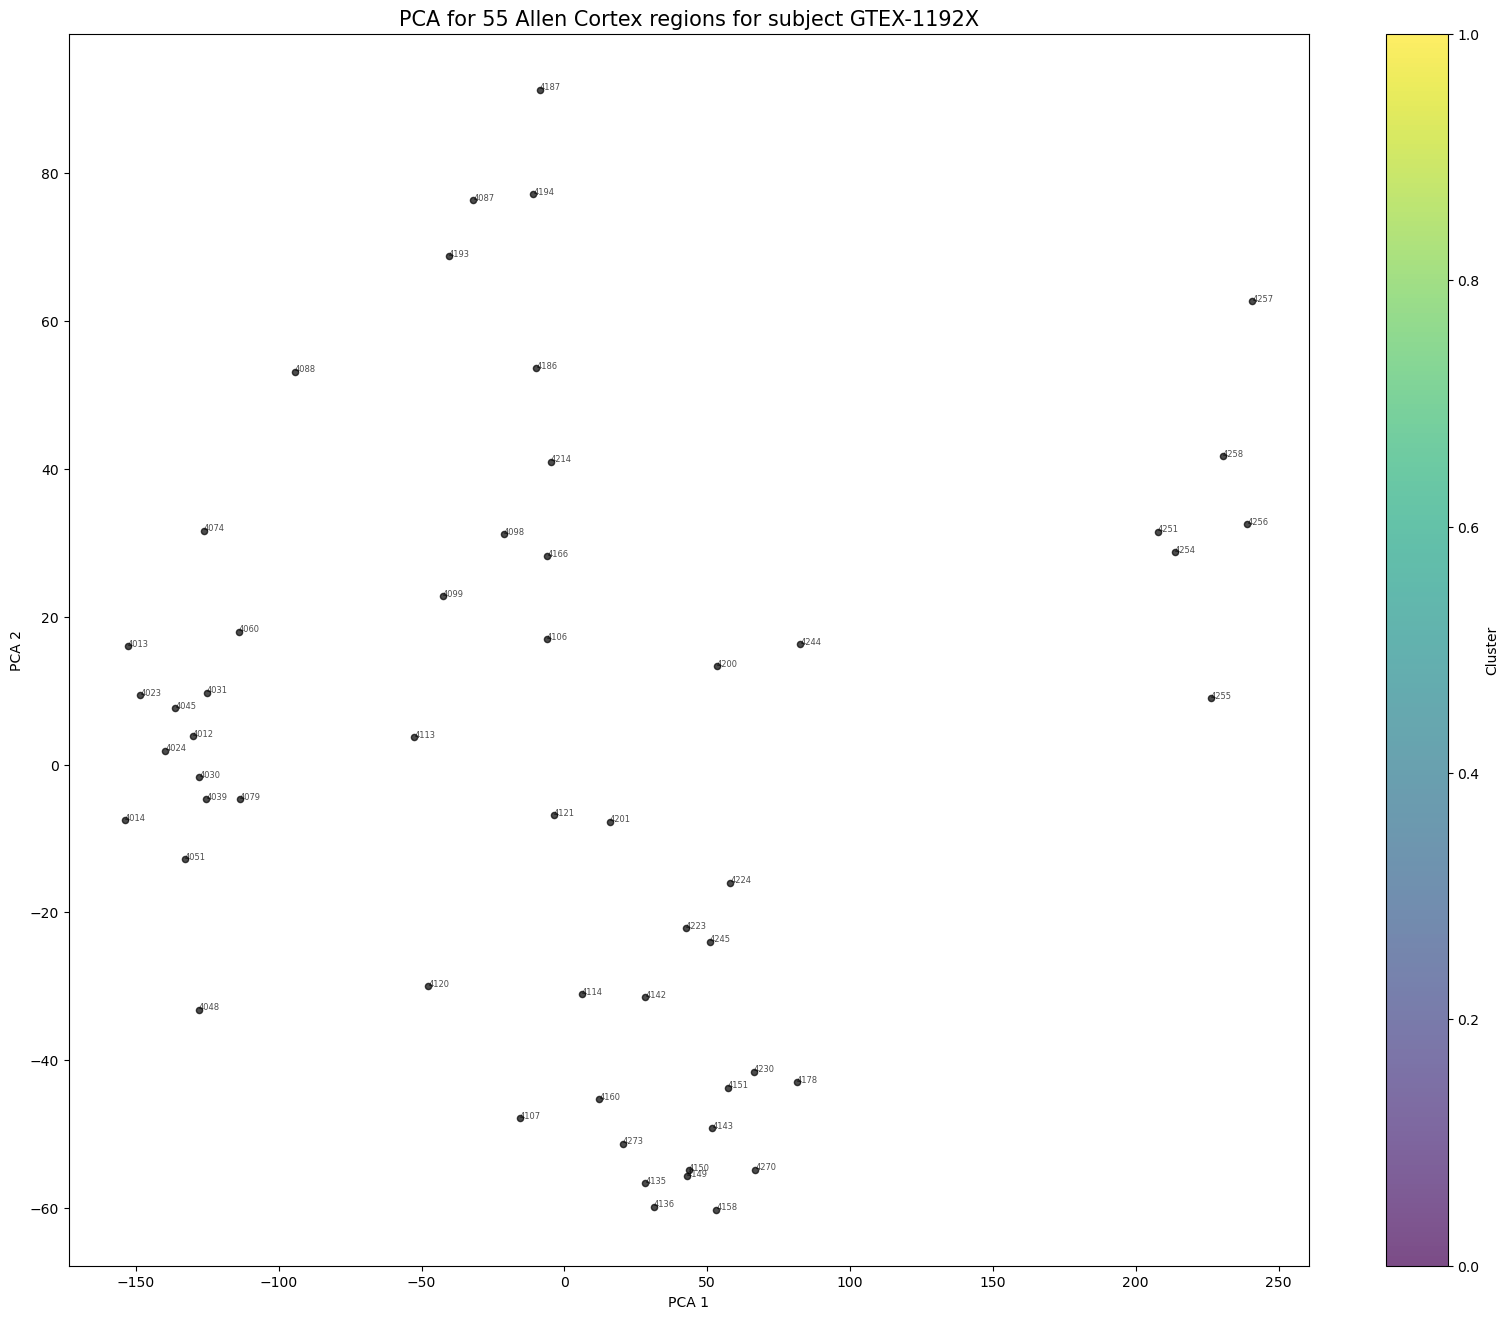

In [6]:
# A new plot with only the CORTEX allen region
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Example: Load your data into a pandas DataFrame
# Replace this with your actual data
subject = 'GTEX-1192X'
mat = go_prediction_dict[subject].iloc[:, :55].values.T
region_names = go_prediction_dict[subject].columns[:55]

# Step 1: Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(mat)

# Step 2: Apply PCA to reduce data to 3 components (3D)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

colors='black'

# Step 5: Plot the PCA result for the first two components, coloring each point based on all three components
plt.figure(figsize=(20, 16))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=colors, s=20, alpha=0.7)

# Step 6: Annotate the dots with row names
for i, txt in enumerate(region_names):
    plt.annotate(txt, (pca_result[i, 0], pca_result[i, 1]), fontsize=6, alpha=0.7)

plt.title(f'PCA for {55} Allen Cortex regions for subject {subject}', fontsize=15)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

In [7]:
len(go_prediction_dict[subject].columns[:55])

55

In [8]:
go_prediction_dict[subject].columns[:55]

Index(['4012', '4013', '4014', '4023', '4024', '4030', '4031', '4039', '4045',
       '4048', '4051', '4060', '4074', '4079', '4087', '4088', '4098', '4099',
       '4106', '4107', '4113', '4114', '4120', '4121', '4135', '4136', '4142',
       '4143', '4149', '4150', '4151', '4158', '4160', '4166', '4178', '4186',
       '4187', '4193', '4194', '4200', '4201', '4214', '4223', '4224', '4230',
       '4244', '4245', '4251', '4254', '4255', '4256', '4257', '4258', '4270',
       '4273'],
      dtype='object')